# Advanced: Fitting Limb Darkening Coefficients

**NOTE**: support for fitting `ld_coeffs` as well as custom constraints was fixed in PHOEBE 2.3.30.  This notebook will fail to run on earlier versions.

## Create Fake Example Observations

Here we'll create fake observations (ignoring noise or reasonable uncertainties) to demonstrate how to fit limb-darkening coefficients for multiple light curve datasets, including two that we want to keep in sync due to having a shared passband.

Note that limb-darkening coefficients parameters (`ld_coeffs`) are not visible by default as `ld_mode` defaults to 'interp'.  See the [limb-darkening tutorial](./limb_darkening.ipynb) for more details.

In [1]:
import phoebe
import numpy as np

phoebe.logger('error') # just to ignore many limb-brightening warnings

b = phoebe.default_binary()

b.add_dataset('lc', times=phoebe.linspace(0,1,51), passband='Johnson:V', dataset='Vband1')
b.add_dataset('lc', times=phoebe.linspace(1,2,51), passband='Johnson:B', dataset='Bband1')
b.add_dataset('lc', times=phoebe.linspace(2,3,51), passband='Johnson:B', dataset='Bband2')

b.set_value_all('ld_mode', 'manual')

b.set_value_all('ld_coeffs', dataset='Vband1', value=[0.3, 0.7])
b.set_value_all('ld_coeffs', dataset='Bband*', value=[0.4, 0.6])

b.set_value_all('irrad_method', 'none')

b.run_compute()

for ds in b.datasets:
    b.set_value('fluxes', dataset=ds, context='dataset', value=b.get_value('fluxes', dataset=ds, context='model'))
    b.set_value('sigmas', dataset=ds, context='dataset', value=0.1*np.ones_like(b.get_value('fluxes', dataset=ds, context='model')))

b.set_value_all('ld_coeffs', [0.5, 0.5])
b.set_value('incl@binary', 90)

b.remove_model(model='latest')

100%|██████████| 151/151 [00:01<00:00, 80.91it/s]


<ParameterSet: 7 parameters | datasets: Bband1, Vband1, Bband2>

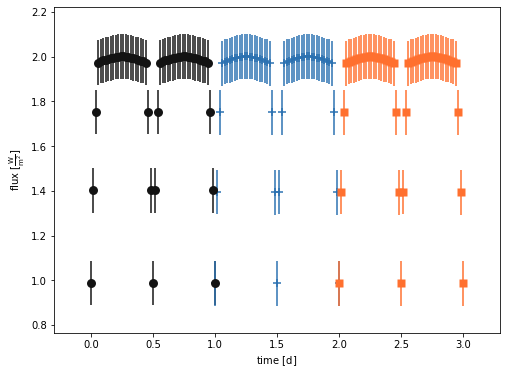

In [2]:
_ = b.plot(show=True)

## Optional: Constraining Limb-Darkening Coefficients

In this case, we have three datasets, so 6 different `ld_coeffs` parameters (and would have 2 `ld_coeffs_bol` parameters, but we'll leave `ld_mode_bol` to be 'lookup')

In [3]:
print(b.filter(qualifier='ld_coeffs'))

ParameterSet: 6 parameters
   ld_coeffs@primary@Vband1@da...: [0.5 0.5]
   ld_coeffs@secondary@Vband1@...: [0.5 0.5]
   ld_coeffs@primary@Bband1@da...: [0.5 0.5]
   ld_coeffs@secondary@Bband1@...: [0.5 0.5]
   ld_coeffs@primary@Bband2@da...: [0.5 0.5]
   ld_coeffs@secondary@Bband2@...: [0.5 0.5]


There are 2 different `ld_coeffs` parameters (one for each component) for each dataset, as limb-darkening is passband dependent.  However, in this case, two of the datasets are the same passband, so when fitting, we want to ensure these are always using the same value and kept in sync.  

To do that, we can create a custom constraint via [b.add_constraint](../api/phoebe.frontend.bundle.Bundle.add_constraint.md) (for more details see [Advanced: Custom Constraints](constraints_custom.ipynb)).

In [4]:
for component in ['primary', 'secondary']:
    lhs = b.get_parameter(qualifier='ld_coeffs', component=component, dataset='Bband2')
    rhs = b.get_parameter(qualifier='ld_coeffs', component=component, dataset='Bband1') 
    b.add_constraint(lhs, rhs)

In [5]:
print(b.filter(qualifier='ld_coeffs'))

ParameterSet: 8 parameters
   ld_coeffs@primary@Vband1@da...: [0.5 0.5]
   ld_coeffs@secondary@Vband1@...: [0.5 0.5]
   ld_coeffs@primary@Bband1@da...: [0.5 0.5]
   ld_coeffs@secondary@Bband1@...: [0.5 0.5]
C  ld_coeffs@primary@Bband2@da...: [0.5 0.5]
C  ld_coeffs@secondary@Bband2@...: [0.5 0.5]
     ld_coeffs@primary@constraint: 1.000000 * {ld_coeffs@primary@Bband1@dataset}
   ld_coeffs@secondary@constraint: 1.000000 * {ld_coeffs@secondary@Bband1@dataset}


## Optimizing

For optimizers, we need to set the `fit_parameters`.  Each index in the referenced `ld_coeffs` parameters will be fitted separately.  If wanting to only fit a subset of the indices, those can be referenced with square brackets in the twigs sent to `fit_parameters` (i.e. `'ld_coeffs[0]@Vband1@primary'`), otherwise all will be included when expanding to the available parameters.

Here we'll fit all `ld_coeffs` for the unconstrained datasets (Vband1 and Bband1) and allow Bband2 to be handled by their constraints.

In [6]:
b.add_solver('optimizer.nelder_mead', 
             maxiter=50, maxfev=200, xatol=1e-2, 
             solver='nm_solver')

<ParameterSet: 12 parameters | qualifiers: maxfev, adaptive, compute, comments, priors_combine, xatol, initial_values, fatol, priors, fit_parameters, maxiter, expose_lnprobabilities>

In [7]:
b.set_value('fit_parameters', ['ld_coeffs@Vband1', 'ld_coeffs@Bband1'])

In [8]:
b.get_value('fit_parameters')

['ld_coeffs@Vband1', 'ld_coeffs@Bband1']

In [9]:
b.get_value('fit_parameters', expand=True)

['ld_coeffs[0]@primary@Vband1@lc@dataset',
 'ld_coeffs[1]@primary@Vband1@lc@dataset',
 'ld_coeffs[0]@secondary@Vband1@lc@dataset',
 'ld_coeffs[1]@secondary@Vband1@lc@dataset',
 'ld_coeffs[0]@primary@Bband1@lc@dataset',
 'ld_coeffs[1]@primary@Bband1@lc@dataset',
 'ld_coeffs[0]@secondary@Bband1@lc@dataset',
 'ld_coeffs[1]@secondary@Bband1@lc@dataset']

In [10]:
b.run_solver(solver='nm_solver', solution='nm_sol')

1225it [03:56, 11.23it/s]                      

<ParameterSet: 13 parameters | qualifiers: success, fitted_values, fitted_uniqueids, comments, nfev, fitted_twigs, adopt_values, initial_values, message, adopt_parameters, adopt_distributions, niter, fitted_units>

In [11]:
print(b.get_value(qualifier='message', solution='nm_sol'))

Maximum number of iterations has been exceeded.


We can now see when adopting the solution that the Bband2 coefficients will also be adopted, according to the constraints we created.

In [12]:
print(b.adopt_solution(solution='nm_sol'))

ParameterSet: 6 parameters
   ld_coeffs@primary@Vband1@da...: [0.49850561 0.5052455 ]
   ld_coeffs@secondary@Vband1@...: [0.4964407  0.51182619]
   ld_coeffs@primary@Bband1@da...: [0.50101418 0.50600377]
   ld_coeffs@secondary@Bband1@...: [0.49747317 0.50522276]
C  ld_coeffs@primary@Bband2@da...: [0.50101418 0.50600377]
C  ld_coeffs@secondary@Bband2@...: [0.49747317 0.50522276]


## Attaching and Plotting Distributions
When attaching distributions, each (applicable) index in the `ld_coeffs` array must have its own attached distribution.

When calling [b.add_distribution](../api/phoebe.frontend.bundle.Bundle.add_distribution.md), the index must be included using the square bracket notation.  Alternatively, to add a copy of the same distribution to all matching parameters, `allow_multiple_matches=True` can be passed.

Here we'll show several different syntaxes that are valid to attach distribution to the `ld_coeffs` parameters.

In [13]:
b.add_distribution('ld_coeffs[0]@primary@Vband1', phoebe.gaussian_around(0.1), 
                   distribution='mydist')

<ParameterSet: 1 parameters>

In [14]:
b.add_distribution({'ld_coeffs[1]@primary@Vband1': phoebe.gaussian_around(0.1),
                    'ld_coeffs[0]@secondary@Vband1': phoebe.gaussian_around(0.1),
                    'ld_coeffs[1]@secondary@Vband1': phoebe.gaussian_around(0.1)}, 
                   distribution='mydist')

<ParameterSet: 3 parameters | components: secondary, primary>

In [15]:
try:
    b.add_distribution('ld_coeffs@secondary@Vband', phoebe.gaussian_around(0.1), 
                       distribution='mydist')
except Exception as err:
    print(err)

[{'twig': 'ld_coeffs@secondary@Vband', 'value': <distl.gaussian_around scale=0.1 value=UNSET>, 'distribution': 'mydist'}] result in zero matches to existing parameters - cannot add distributions


In [16]:
b.add_distribution('ld_coeffs@Bband1', phoebe.gaussian_around(0.1), 
                   distribution='mydist', allow_multiple_matches=True)

<ParameterSet: 4 parameters | components: secondary, primary>

In [17]:
print(b.get_distribution('mydist'))

ParameterSet: 8 parameters
   ld_coeffs[0]@primary@Vband1...: <distl.gaussian_around scale=0.1 value=0.4985056050419507 unit=>
   ld_coeffs[1]@primary@Vband1...: <distl.gaussian_around scale=0.1 value=0.5052454981569214 unit=>
   ld_coeffs[0]@secondary@Vban...: <distl.gaussian_around scale=0.1 value=0.4964407044756223 unit=>
   ld_coeffs[1]@secondary@Vban...: <distl.gaussian_around scale=0.1 value=0.5118261943824614 unit=>
   ld_coeffs[0]@primary@Bband1...: <distl.gaussian_around scale=0.1 value=0.5010141799447345 unit=>
   ld_coeffs[1]@primary@Bband1...: <distl.gaussian_around scale=0.1 value=0.5060037665040753 unit=>
   ld_coeffs[0]@secondary@Bban...: <distl.gaussian_around scale=0.1 value=0.4974731703531481 unit=>
   ld_coeffs[1]@secondary@Bban...: <distl.gaussian_around scale=0.1 value=0.5052227555637787 unit=>


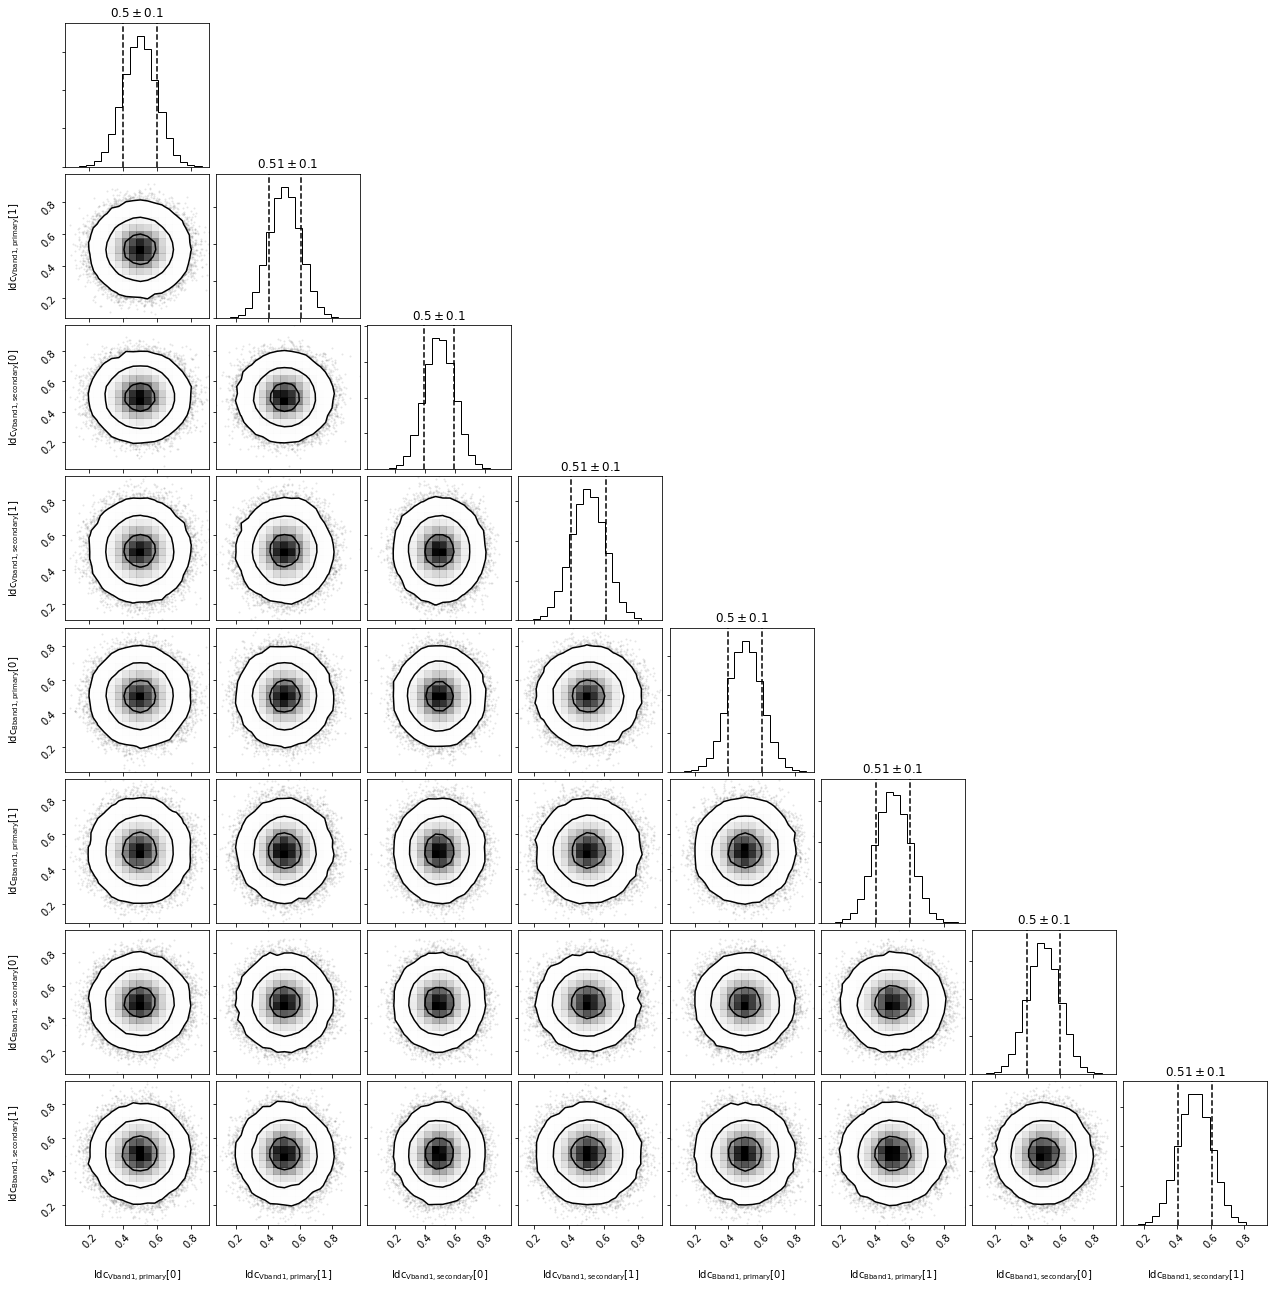

In [18]:
_ = b.plot_distribution_collection('mydist', show=True)

## Samplers

Once distributions are attached, we can now initialize our `init_from` distribution as in any other case.  Here we'll show a quick example using just several iterations and the emcee sampler.

In [19]:
b.add_solver('sampler.emcee', solver='emcee_solver', init_from='mydist', niters=10, nwalkers=16)

<ParameterSet: 13 parameters | qualifiers: init_from_combine, compute, comments, priors_combine, nwalkers, burnin_factor, progress_every_niters, niters, continue_from, priors, init_from, expose_failed, thin_factor>

In [20]:
b.run_solver('emcee_solver', solution='emcee_sol')

1225it [04:10, 11.23it/s]
100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


<ParameterSet: 20 parameters | qualifiers: lnprobabilities, adopt_distributions, lnprob_cutoff, distributions_convert, burnin, failed_samples, thin, fitted_uniqueids, comments, niters, adopt_values, samples, wrap_central_values, acceptance_fractions, progress, nwalkers, fitted_twigs, adopt_parameters, autocorr_times, fitted_units>

Note that the posteriors from the solution do not include the propagated distributions from the constraints, but if applied or sampled, the constraints will continue to be respected.

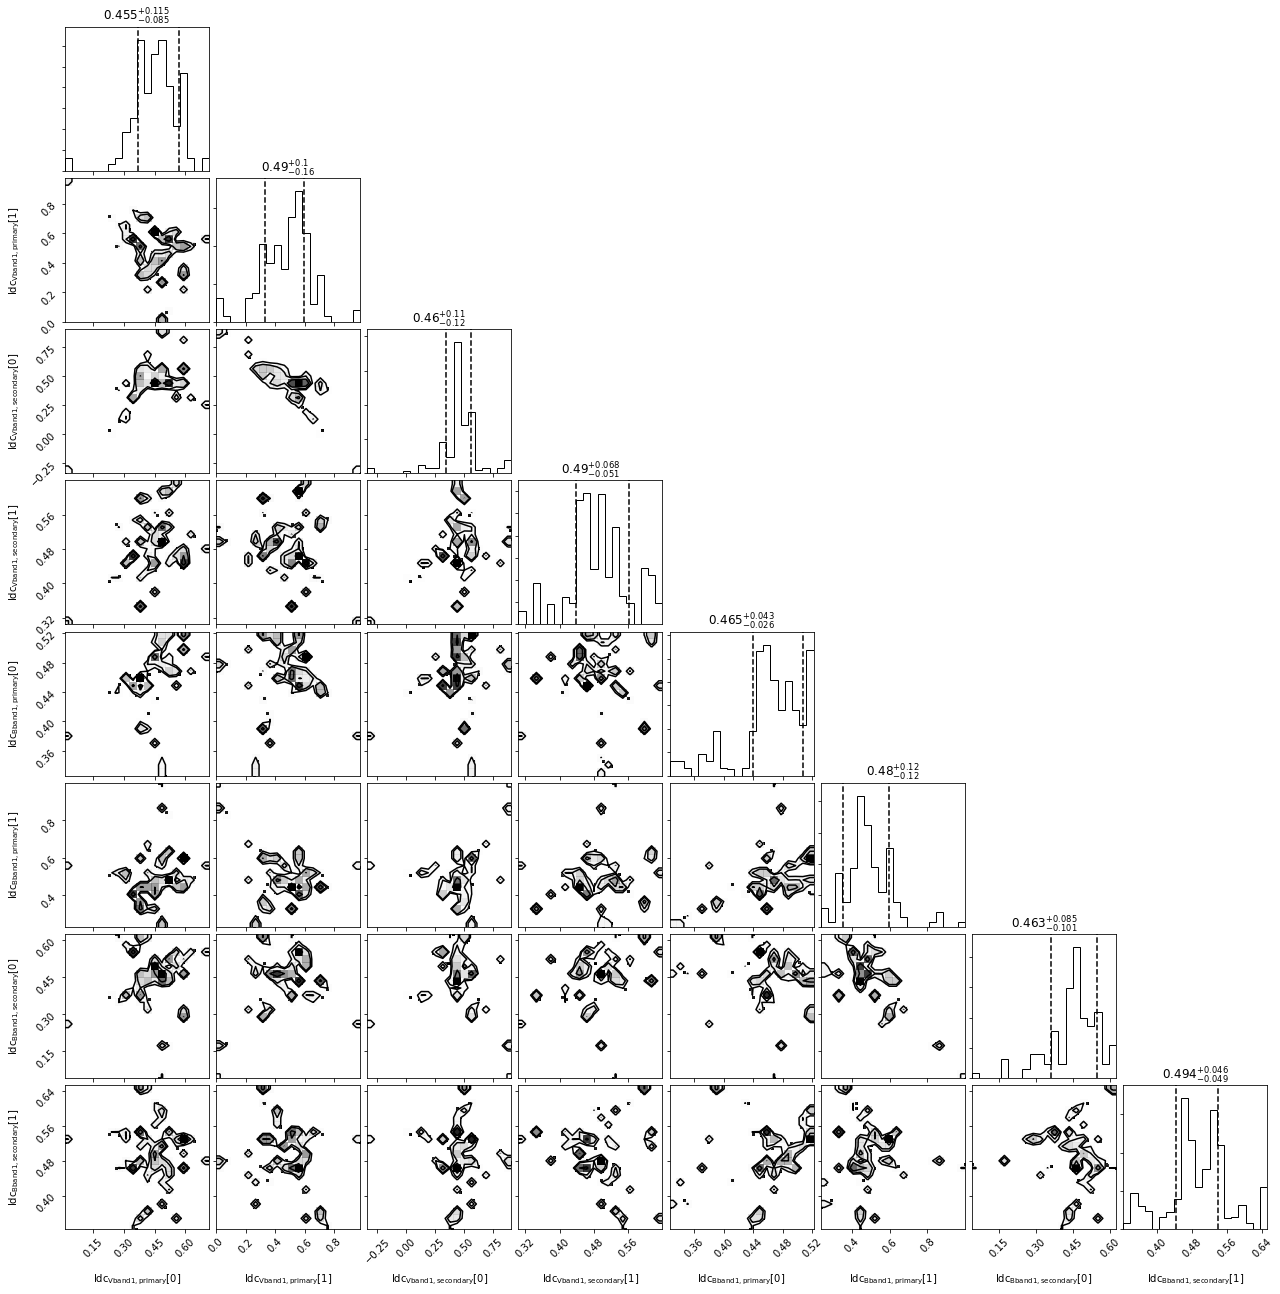

In [21]:
_ = b.plot(solution='emcee_sol', style='corner', show=True)

When inspecting/plotting the solution, the individual elements in the `ld_coeffs` can be referenced (and are expanded to all matches) using the same notation as above, for example:

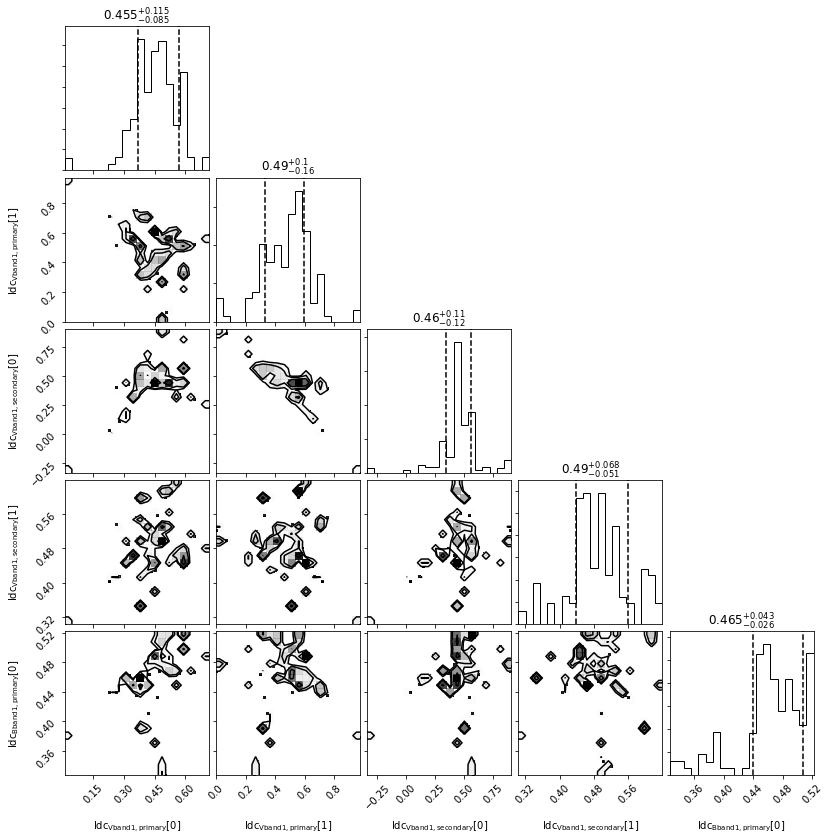

In [22]:
_ = b.plot(solution='emcee_sol', style='corner', 
           adopt_parameters=['ld_coeffs@Vband1', 'ld_coeffs[0]@primary@Bband1'], show=True)

If we now adopt the solution, the posteriors will be stored in a new tagged distribution collection (we'll name it 'emcee_posts') and the central values will be adopted, including those for the constrained Bband2 dataset.

In [23]:
b.adopt_solution('emcee_sol', distribution='emcee_posts')

<ParameterSet: 14 parameters | contexts: distribution, dataset>